# EfficientDet: small step for an optimizer gient giant leap datascientists
### **Real world problem** | **Object detection** | **PyTorch** | **Optical character detection**

**Hello**! This is the second and the last part of an OCR project. Here we are going to use previously written [notebook](https://www.kaggle.com/ivankalinchuk/ocr-efficientdet-with-pytorch-part-1-2-training) (part 1 of 2), where we learned how to train an EfficientDet model with PyTorch. Having learned our model, we have weights, which need to be loaded into a model.

**Import all apropriate libraries**

In [1]:
!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [2]:
from colorama import Fore, Style

In [3]:
import sys
sys.path.insert(0, "../input/timm-efficientdet-pytorch-fixdiv")
sys.path.insert(0, "../input/omegaconf")
sys.path.insert(0, "../input/weightedboxesfusion")

import os
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet.efficientdet import HeadNet
from ensemble_boxes import *

print(f'{Fore.GREEN} successfully installed! {Style.RESET_ALL}')

 successfully installed! 


Lets set up some constants for our project, so as to make it more undestandable and easy to manage.

In [4]:
IMG_WIDTH, IMG_HEIGHT = 256, 256
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
TEST_DATA_PATH = '../input/charaters-for-detection-classification/real_world_test/'
WEIGHTS_PATH = '../input/efficientdet-trained-model-for-ocr/best-checkpoint-004epoch/best-checkpoint-004epoch.bin'

In [5]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=256, width=256, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [6]:
class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TEST_DATA_PATH}/{image_id}.png', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [7]:
def get_file_name(file_name_with_extension):
    return os.path.splitext(file_name_with_extension)[0]

In [8]:
def collate(batch):
    return tuple(zip(*batch))

In [9]:
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{TEST_DATA_PATH}/*.png')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)


As we already have a model trained, we just need a function, which returns an object of pytorch model with loaded weights.

In [10]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=256
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path,map_location='cpu') #remove map_loc... if running on gpu
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cpu() #.cuda

net = load_net(WEIGHTS_PATH)

In [11]:
def make_predictions(images, score_threshold=0.22):
    images = torch.stack(images).cpu().float() #.cuda
    predictions = []
    with torch.no_grad():
        det = net(images, torch.tensor([1]*images.shape[0]).float().cpu()) #cuda
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return [predictions]

def run_wbf(predictions, image_index, image_size=IMG_WIDTH, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [12]:
def get_images(data_loader, num_images):
    images = []
    for j, (img, name) in enumerate(data_loader):
        if (j < num_images):
            images.append(img[0])
        else:
            break
    return tuple(images)

The next cell is one of the most delightful one. We predict! Also I've added a time module so as to calculate execution time, but you are free to delete it, as it's optional. 

it took  5.791271209716797  seconds for the model predict 10 images
Average= 0.5791271209716797 seconds


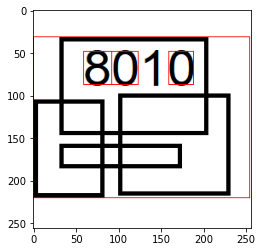

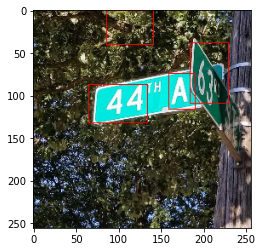

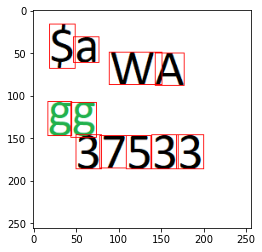

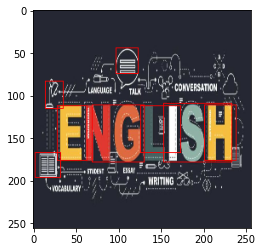

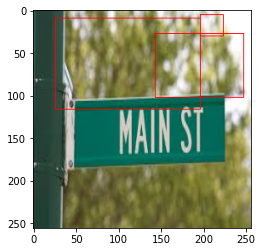

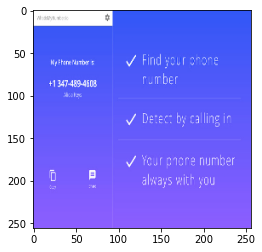

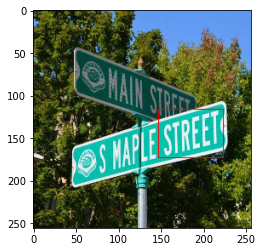

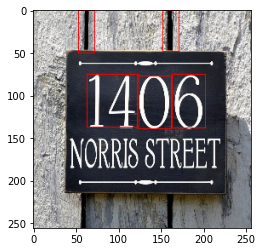

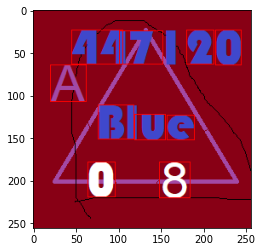

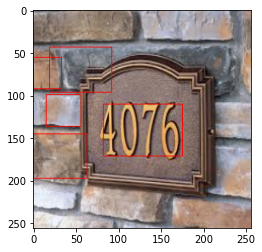

In [13]:
import matplotlib.pyplot as plt
import time

num_test_images = 10
images = get_images(data_loader, num_test_images)

predict_start_time = time.time()
predictions = make_predictions(images)
predict_finish_time =_finish_time = time.time()
predict_time = predict_finish_time - predict_start_time
print(f'it took {Fore.CYAN}', predict_time,f' seconds{Style.RESET_ALL} for the model predict', num_test_images, 'images')
print('Average=', predict_time / num_test_images,'seconds')
#fig, ax = plt.subplots(10, figsize=(16, 16))

for i in range(num_test_images):
    sample = images[i].permute(1,2,0).cpu().numpy()
    boxes, scores, labels = run_wbf(predictions, image_index=i)
    boxes = boxes.astype(np.int32).clip(min=0, max=511)


    for box in boxes:
        cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)
    plt.imshow(sample)
    plt.show()
    #ax[i].imshow(sample)